# Covariance Matrix

_Alone, we can do so little; together, we can do so much_ - Helen Keller

Concepts
- Portfolio Risk Analysis
- Covariance Matrix Estimation

References
- FRM Part II Exam Book Investment Management Ch. 5
- Chen et al., “Shrinkage Algorithms for MMSE Covariance Estimation” IEEE Trans. # on Sign. Proc., Volume 58, Issue 10, October 2010.
- Olivier Ledoit and Michael Wolf, "Honey, I Shrunk the Sample Covariance Matrix", July 2003, The Journal of Portfolio Management 30(4)
- Florin Spinu, “An algorithm for computing risk parity weights,” SSRN, 2013.

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from pandas import DataFrame
import cvxpy as cp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.covariance import LedoitWolf, OAS, EmpiricalCovariance
from sklearn import cluster
from finds.utils import ColorMap
from finds.readers import FFReader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# %matplotlib qt
VERBOSE = 0

## Portfolio risk analysis


In [2]:
# Retrieve industry returns from Ken French Data Library website
symbol = '49_Industry_Portfolios'
ff = FFReader(symbol)
keep = ff[0].index[(ff[0] > -99).all(axis=1)]
rets = (ff[0] / 100).reindex(keep)
caps = (ff[4] * ff[5] * 10e6).reindex(keep)   # number of firms x avg market cap
weights = caps.iloc[-1] / caps.iloc[-1].sum()

In [3]:
X = (rets - rets.mean(axis=0))    # demean by industry
sigma = 12 * X.T @ X / len(X)     # annualized covariance matrix
Y = caps.iloc[-1]\
        .rename('cap')\
        .to_frame()\
        .join(DataFrame({'vol': np.sqrt(np.diag(sigma))}, index=X.columns))\
        .sort_values('cap', ascending=False)

Text(0.5, 0, 'monthly returns (1969-07 to 2024-03)')

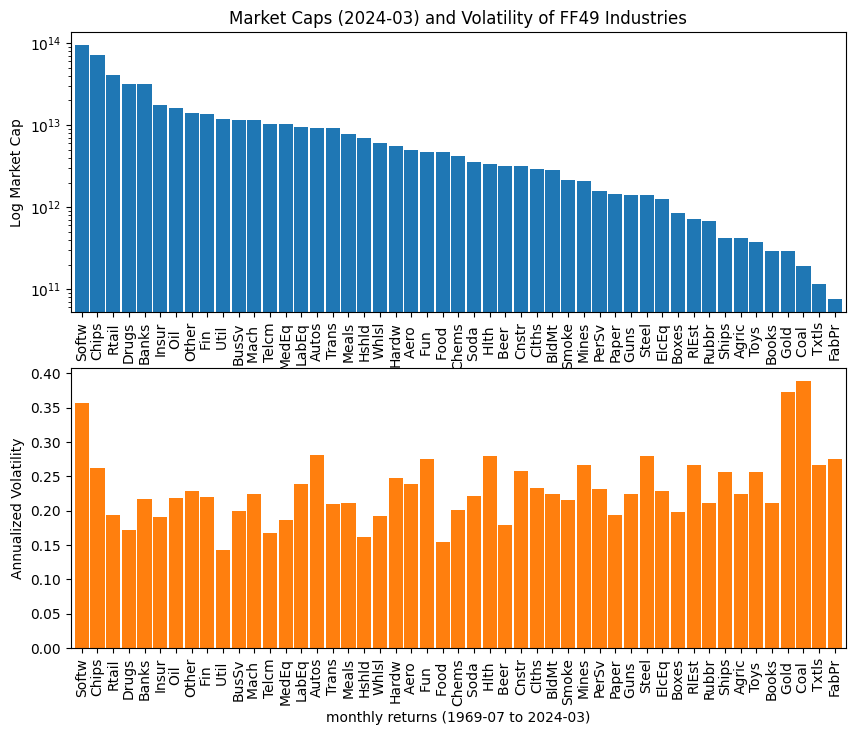

In [4]:
# Plot annualized volatility and market caps of industries
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
Y['cap'].plot.bar(ax=ax[0], color="C0", width=0.9)
ax[0].set_yscale('log')
ax[0].set_title(f"Market Caps ({X.index[-1]}) and Volatility of FF49 Industries")
ax[0].set_ylabel(f"Log Market Cap")
Y['vol'].plot.bar(ax=ax[1], color="C1", width=0.9)
ax[1].set_ylabel(f"Annualized Volatility")
ax[1].set_xlabel(f"monthly returns ({X.index[0]} to {X.index[-1]})")

### Risk budgetting

- Portfolio Risk - volatility of (market) portfolio is
  $\sigma_P = W^T \Sigma W$, where $W$ is the vector of securities' weights in the portfolio and $\Sigma$ is the covariance matrix of their returns

- Covariance: $\sigma_{iP} = \rho_{iP} \cdot \sigma_i \cdot \sigma_P$, where $\rho_{iP} is the correlation of the returns of security $i$ wrt portfolio $P$

- Beta - the systematic risk risk of security vs portfolio, or
  regression slope of the security's returns on portfolio returns: 
  $\beta_i = \dfrac{\sigma_{iP}}{\sigma_P^2}$

- Marginal Contribution to Risk -sensitivity of portfolio volatility to small change in weight:
  $\dfrac{\partial \sigma_P}{\partial w_i} = \dfrac{\sigma_{iP}}{\sigma_P}$

- Percent Contribution to Risk - what fraction of portfolio risk would
  change approximately if this security was deleted from the portfolio: $\beta_i \cdot w_i$.  This risk decomposition that sums to 1.

- Contribution to risk - this decomposition of portfolio risk sums to
  portfolio volatility. It can also be expressed as asset weight times asset volatility
  times correlation with portfolio: 
  $\beta_i \cdot w_i \cdot \sigma_P = w_i \cdot \sigma_i \cdot \rho_{iP}$.


In [5]:
# Helper to compute portfolio risk budget
def risk_budget(w, sigma, labels):
    """Compute portfolio risk analytics"""
    sigma_ = np.array(sigma) * 100 * 100   # express as percent returns
    w_ =  np.array(w)
    
    # Portfolio volatility (percent)
    vol = np.sqrt(w_.T @ sigma_ @ w_)
    
    # Covariance of each security wrt market portfolio
    cov = sigma_ @ w_

    # Beta of each security wrt market portfolio
    beta = cov / (w_.T @ sigma_ @ w_)

    # Marginal Contribution to Risk of each security
    marginal = beta * vol
    
    # Percent Contribution to Risk
    percent = beta * w_ * 100

    # Contribution to Risk
    contrib = marginal * w_

    return DataFrame({'weight': list(w),
                      'Beta': list(beta),
                      'MCR(%)': list(marginal),
                      'PCR(%)': list(percent),
                      'CR': list(contrib)},
                     index=labels)

In [6]:
vol = np.sqrt(weights.T @ sigma @ weights)  # market portfolio risk
print(f"Market Portfolio Risk Budget (vol={vol*100:.2f}%)")
risk_budget(weights, sigma, weights.index).sort_values('CR', ascending=False)

Market Portfolio Risk Budget (vol=19.35%)


,weight,Beta,MCR(%),PCR(%),CR
Softw,0.192584,1.574845,30.475899,30.328962,5.869164
Chips,0.142872,1.179219,22.819870,16.847733,3.260319
Rtail,0.081477,0.827907,16.021394,6.745528,1.305373
Banks,0.064025,0.845579,16.363371,5.413810,1.047663
Drugs,0.064479,0.589820,11.414007,3.803093,0.735962
Fin,0.027743,0.969658,18.764520,2.690145,0.520588
Insur,0.035976,0.728126,14.090454,2.619527,0.506922
Other,0.028330,0.910110,17.612159,2.578348,0.498954
Mach,0.023061,0.972623,18.821886,2.242987,0.434056
BusSv,0.023067,0.955382,18.488250,2.203781,0.426469


### Risk parity portfolios

To construct a simple risk-parity portfolio (RPP): first equalize the
risk contributions of the asset classes and then apply leverage
to achieve a target volatility

A desired risk budget can be approximated as a convex optimization problem, see Spinu (2013):
$$ \min_{w} \dfrac{1}{2} w^T \Sigma W - \sum_i b_i \log{w_i}$$
subject to non-negative weights $w_i >= 0$,
where $b_i = 1/N$ is the desired RPP risk budget


In [7]:
# Set up variables and constraints
N = len(sigma)
b = np.ones(N)/N            # risk parity
W = cp.Variable(N)          # portfolio weights to solve for
constraints = [W >= 0]      # non-negative weights constraint

In [8]:
# Solve objective
obj = 0.5 * cp.quad_form(W, sigma) - cp.sum(cp.multiply(b, cp.log(W)))  
prob = cp.Problem(cp.Minimize(obj), constraints)
prob.solve()

2.6150587857892416

In [9]:
# normalize solution weights
rpp = (W/cp.sum(W)).value

In [10]:
vol = np.sqrt(rpp.T @ sigma @ rpp)
print(f"Risk Parity Portfolio (vol={vol*100:.2f}%)")
risk_budget(rpp, sigma, weights.index).sort_values('weight', ascending=False)

Risk Parity Portfolio (vol=16.49%)


,weight,Beta,MCR(%),PCR(%),CR
Util,0.038752,0.526629,8.682950,2.040816,0.336486
Food,0.030451,0.670192,11.049988,2.040816,0.336486
Smoke,0.029572,0.690115,11.378474,2.040816,0.336486
Telcm,0.028807,0.708446,11.680724,2.040816,0.336486
Drugs,0.028718,0.710630,11.716722,2.040816,0.336486
Gold,0.028147,0.725044,11.954388,2.040816,0.336486
Beer,0.027761,0.735127,12.120636,2.040817,0.336486
Hshld,0.026958,0.757049,12.482075,2.040816,0.336486
Soda,0.024502,0.832909,13.732845,2.040816,0.336486
Oil,0.024255,0.841397,13.872790,2.040816,0.336486


## Covariance matrix estimation

### Principal components

Each component can be interpreted as weights in a portfolio holdings the industries as assets.  The projection of industry returns on a component simply computes the returns of the corresponding portfolio.

In [11]:
# Fit PCA
pca = PCA().fit(X)

# Retrieve components, and sign flip if necessary
loadings = (np.diag(pca.singular_values_) @ pca.components_).T  # compute loadings by column
components = DataFrame.from_records(pca.components_.T, index=X.columns)
components *= np.sign(components.sum(axis=0))

# Compute projections, can be interpreted as portfolio returns
proj = pca.transform(X)
proj *= np.sign(np.sum(pca.components_, axis=1))  # flip signs if necessary

# Equal weighted market average return
avg = X.mean(axis=1)


The first component resembles a portfolio with long positions invested across all assets, and explains more than half the variance.  The other components resemble long-short spread portfolios that explain incremental amounts of variance.

In [12]:
K = 20
print(f"Top {K} principal components")
DataFrame({
    'frac weights +ve': np.mean(components.iloc[:, :K].values >= 0, axis=0),
    'sum weights': np.sum(components.iloc[:, :K].values, axis=0),
    'sum sqr weights': np.sum((components.iloc[:, :K].values)**2, axis=0),
    'sum abs weights': np.sum(np.abs(components.iloc[:, :K].values), axis=0),
    'corr avg ret':  [np.corrcoef(avg, proj[:, i])[0, 1] for i in range(K)],
    'cumulative expl ratio': np.cumsum(pca.explained_variance_ratio_[:K])},
          index=[f"PC{i+1}" for i in range(K)]).round(4)

Top 20 principal components


,frac weights +ve,sum weights,sum sqr weights,sum abs weights,corr avg ret,cumulative expl ratio
PC1,1.0000,6.8347,1.0,6.8347,0.9988,0.5604
PC2,0.2449,0.0869,1.0,4.1490,0.0043,0.6235
PC3,0.5102,0.2746,1.0,3.5353,0.0107,0.6636
PC4,0.6735,0.9467,1.0,5.1509,0.0356,0.7006
PC5,0.4898,0.5331,1.0,5.2453,0.0178,0.7299
PC6,0.5510,0.7318,1.0,5.5496,0.0213,0.7521
PC7,0.5714,0.0774,1.0,5.5749,0.0020,0.7701
PC8,0.5102,0.0148,1.0,4.9275,0.0003,0.7843
PC9,0.4898,0.1839,1.0,5.1437,0.0043,0.7984
PC10,0.4694,0.0692,1.0,5.6381,0.0015,0.8104


__Spectral Clustering__

- Component 1 appears to load on the average market factor (so-called beta risk)
- Component 2 can be interpreted as loading on a commodities factor

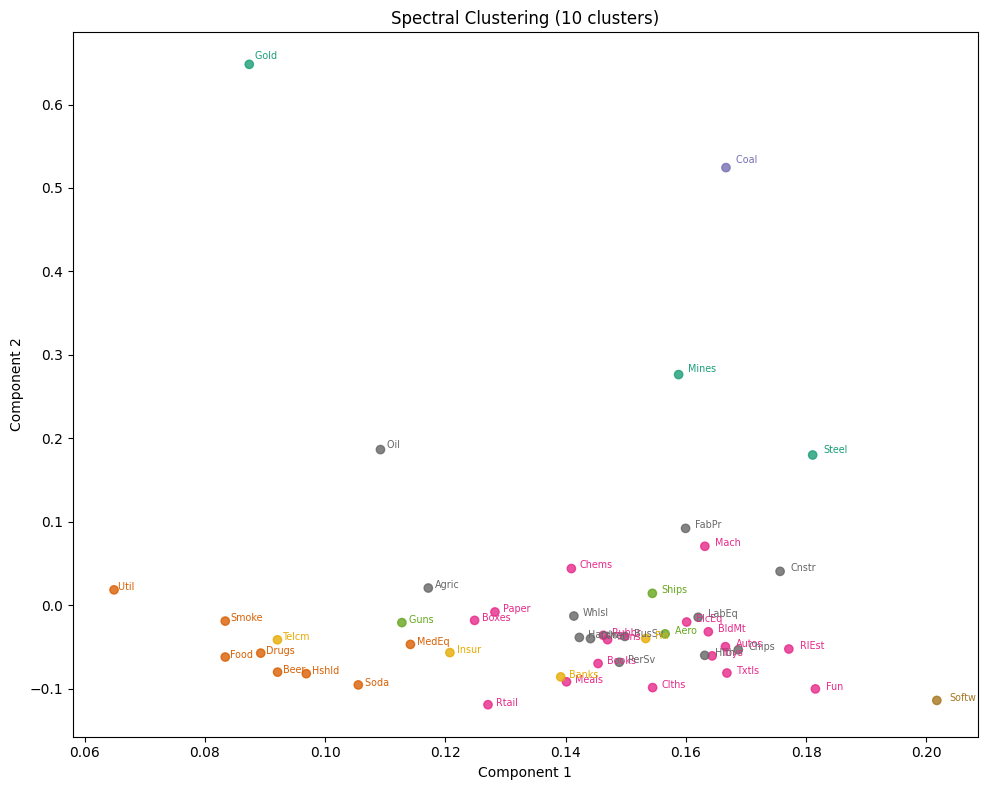

In [47]:
# Spectral clustering
spectral = cluster.SpectralClustering(
    n_clusters=10,
    eigen_solver="arpack",
    #affinity="nearest_neighbors",
    random_state=42,
)
spectral.fit(X.T)   # number of features equals the number observations dates
cmap = ColorMap(spectral.n_clusters, colormap='Dark2')
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(components.iloc[:, 0], components.iloc[:, 1],
           c=cmap[spectral.labels_], alpha=.8)
for t, c, xy in zip(components.index, spectral.labels_,
                    components.iloc[:, :2].values):
    ax.annotate(text=t, xy=xy, xytext=xy * 1.01, color=cmap[c], fontsize='x-small')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title(f"Spectral Clustering ({spectral.n_clusters} clusters)")
plt.tight_layout()
plt.show()

In [48]:
DataFrame({'cluster': spectral.labels_}, index=components.index).sort_values('cluster')

,cluster
Steel,0
Mines,0
Gold,1
Drugs,2
MedEq,2
Util,2
Hshld,2
Smoke,2
Beer,2
Soda,2


### EWMA

The Exponentially-Weighted Moving Average (EWMA) method simply gives recent data, that may be more relevant for predicting risk, a heavier weight when computing the empirical covariance matrix. In 1996, JP Morgan Risk Metrics proposed a lambda parameter of 0.97,
in other words, where weights placed on historical data decay at a monthly rate of 0.03.

The time it takes for the weight to decay by half is called the __half-life__.


In [15]:
# Compute half-life of risk metrics' lambda for monthly data
def halflife(decay, half=0.5):
    """Returns halflife (t) from its definition: 0.5 = (1-decay)^t"""
    return -np.log(1/half)/np.log(1 - decay)

In [16]:
risk_metrics_lambda = 0.97   # for monthly data
print('Half-life: ', halflife(decay=1-risk_metrics_lambda).round(1), 'months')

Half-life:  22.8 months


In [17]:
def ewma(X, decay):
    """Helper to compute EWMA covariance matrix estimate"""
    weights = (1 - decay)**np.arange(len(X))[::-1]
    return (weights.reshape((1, -1)) * X.T) @ X / weights.sum()

### Shrinkage methods

Covariance matrix estimates can be regularized using shrinkage.
Ledoit and Wolf proposed a close formula to compute the asymptotically
optimal shrinkage parameter (minimizing a MSE criterion).
They shrink the covariance towards the identity matrix:
$$ (1 - \beta) \Sigma + \beta \dfrac{tr(\Sigma)}{N}  I_n $$
where $\beta$ is the shrinkage factor given by Ledoit and Wolf (1993)

Chen et al. proposed the Oracle Approximating Shrinkage (OAS) Estimator
whose convergence is significantly better under the assumption that
the data are Gaussian.


### Global MVP volatility

The out-of-sample (OOS) realized volatility of the Global Minimum Variance (GMV) portfolio can serve as a practical test of the accuracy of covariance matrix
estimation techniques. The GMV is constructed to minimize portfolio volatilty,
hence is very sensitive to small errors in the covariance matrix. It relies
on efficient diversification across assets, and inaccurate covariance
estimates may lead to higher realized volatility if the portfolio
inadequately hedges its positions against risk.

Starting in Jan 2000, we update the covariance matrix estimate monthly, using the rolling past 30 years of data, and record the month-ahead return of the GMV portfolio. At the end of the test sample, we expect the best covariance matrix extimator to realize the minimum returns volatility. 


In [18]:
# Helper method to compute Minimum Variance Portfolio and realized volatility
def gmv(cov, ret):
    """Compute minimum variance portfolio and return"""
    w = np.linalg.inv(cov) @ np.ones((cov.shape[1], 1))
    return float(np.array(ret) @ w/sum(w))

In [31]:
# Rolling monthly evaluation
decay = 0.03      # risk metrics monthly decay rate for EWMA
n_components = 10  # for PCA
split = '2000-01' # start rolling OOS prediction tests from this date

In [32]:
r = {}     # collect realized returns
for date in tqdm(rets.index[rets.index >= split]):
    X_train = rets.iloc[rets.index < date, :][-30*12:]   # 30 years of training data 
    X_test = rets.iloc[rets.index == date, :]      # predict one month ahead returns
    r[date] = {}

    # Empirical covariance
    cov = EmpiricalCovariance().fit(X_train).covariance_
    r[date]['Covariance'] = gmv(cov, X_test)
    r[date]['Diagonal'] = gmv(np.diag(np.diag(cov)), X_test)
    r[date]['EWMA'] = gmv(ewma(X_train, decay=decay), X_test)
    r[date][f"PCA-{n_components}"] = gmv(PCA(n_components).fit(X_train).get_covariance(), X_test)
    r[date]['Identity'] = gmv(np.identity(len(cov)), X_test)    
    r[date]['LW'] = gmv(LedoitWolf().fit(X_train).covariance_, X_test)
    r[date]['OAS'] = gmv(OAS().fit(X_train).covariance_, X_test)

  0%|          | 0/291 [00:00<?, ?it/s]

100%|██████████| 291/291 [01:25<00:00,  3.41it/s]


In [33]:
ts = DataFrame.from_dict(r, orient='index')
vol = ts.std().rename('realized volatility').to_frame()
print('Realized volatility of minimum variance portfolio')
vol.T

Realized volatility of minimum variance portfolio


,Covariance,Diagonal,EWMA,PCA-10,Identity,LW,OAS
realized volatility,0.035649,0.045699,0.040867,0.036571,0.048712,0.034823,0.035177


Plot evaluation period realized volatility of minimum variance portfolios

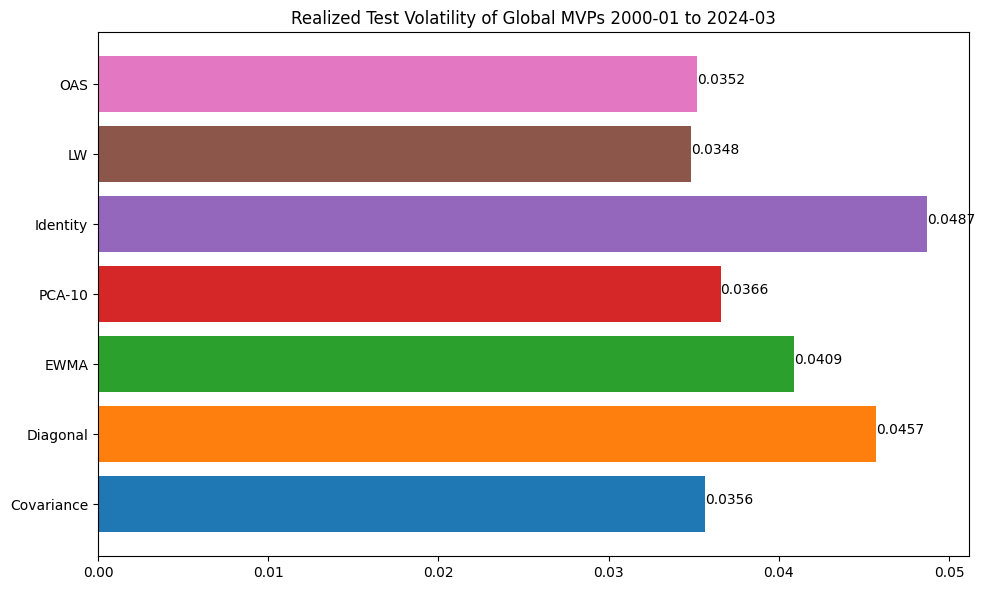

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
values = vol.values.flatten()
ax.barh(vol.index, width=values, color=list(mcolors.TABLEAU_COLORS.values()))
for row, val in enumerate(values):
    ax.annotate(f"{val:.4f}", xy=(val, row))
ax.set_title(f"Realized Test Volatility of Global MVPs {split} to {rets.index[-1]}")
plt.tight_layout()